# Forecast Use of a City Bikeshare System

## Introduction

Bike sharing system allows people to rent bikes automatically through kiosk locations throughout a city. The data generated by this system includes duration of travel, departure and arrival location and time etc. Such information is interesting to researchers to study the mobility of a city, and potentially provide a better bike sharing system.

Our research is based on the historical data of bike rental demand in the Capital Bikeshare program in Washington, D.C. provided by kaggle's 'Bike Demand Sharing Project'. The data contains historical usage patterns and weather data (details below). Our goal is to predict the number of hourly total rentals (count), given the data provided.

--------------------------------
Data Fields

    datetime - hourly date + timestamp  
    season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
    holiday - whether the day is considered a holiday
    workingday - whether the day is neither a weekend nor holiday
    weather -
            1: Clear, Few clouds, Partly cloudy, Partly cloudy 
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    temp - temperature in Celsius
    atemp - "feels like" temperature in Celsius
    humidity - relative humidity
    windspeed - wind speed
    casual - number of non-registered user rentals initiated
    registered - number of registered user rentals initiated
    count - number of total rentals

In [94]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

%matplotlib inline

### Data Preparation
Data source: https://www.kaggle.com/c/bike-sharing-demand/data

In [95]:
train_df = pd.read_csv("../data/train.csv", parse_dates='datetime', index_col='datetime')
test_df = pd.read_csv("../data/test.csv", parse_dates='datetime', index_col='datetime')

print "Shape of train and test datasets provided by Kaggle:"
print train_df.shape, test_df.shape 

Shape of train and test datasets provided by Kaggle:
(10886, 11) (6493, 8)


In [96]:
train_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32


In [97]:
test_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


Note that the testing dataset Kaggle provides doesn't include 'casual' and 'registered' counts. Thus, we cannot use them in our models. The models will be developed with the training dataset only, and the out-of-sample predictions are made on the testing dataset and submitted to Kaggle.

### Exploratory Data Analysis
#### Univariate Analysis
We first look at individual variables' summary statistics and distributions.

In [98]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


array([[<matplotlib.axes.AxesSubplot object at 0x10fc83550>,
        <matplotlib.axes.AxesSubplot object at 0x10dad4610>]], dtype=object)

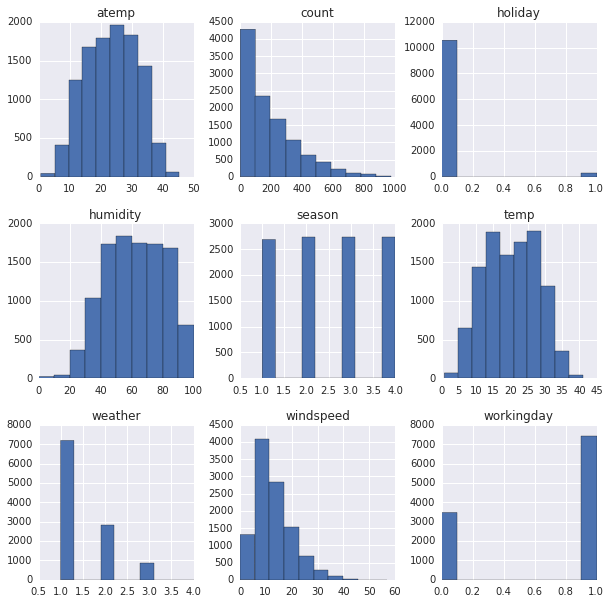

In [99]:
train_df[['season', 'holiday', 'workingday', 'weather','temp','atemp','humidity','windspeed',\
        'count']].hist(sharex=False, sharey=False, figsize=(10,10))

A few takeaways by looking at the summary statistics and historams of all variables.
1. The 'count' variable is heavily skewed to the right. It seems necessary to do a log or sqrt transformation on the variable.
2. Only a very small amount of data are from holidays. This is expected but we do need to pay close attention to these data points as they might be potential outliers.
3. Data points are evenly distributed among four seasons.
4. The 'weather' variable shows that extreme weathers are rare. Again this is expected but we need to look out for outlier days.
5. Windspeed is slightly right-skewed. It doesn't seem to be severe enough to require a transformation but we want to keep an eye on the far right potential outliers.

##### Now let's plot the five continuous variables over time.

array([<matplotlib.axes.AxesSubplot object at 0x11070d590>,
       <matplotlib.axes.AxesSubplot object at 0x10dc47e50>], dtype=object)

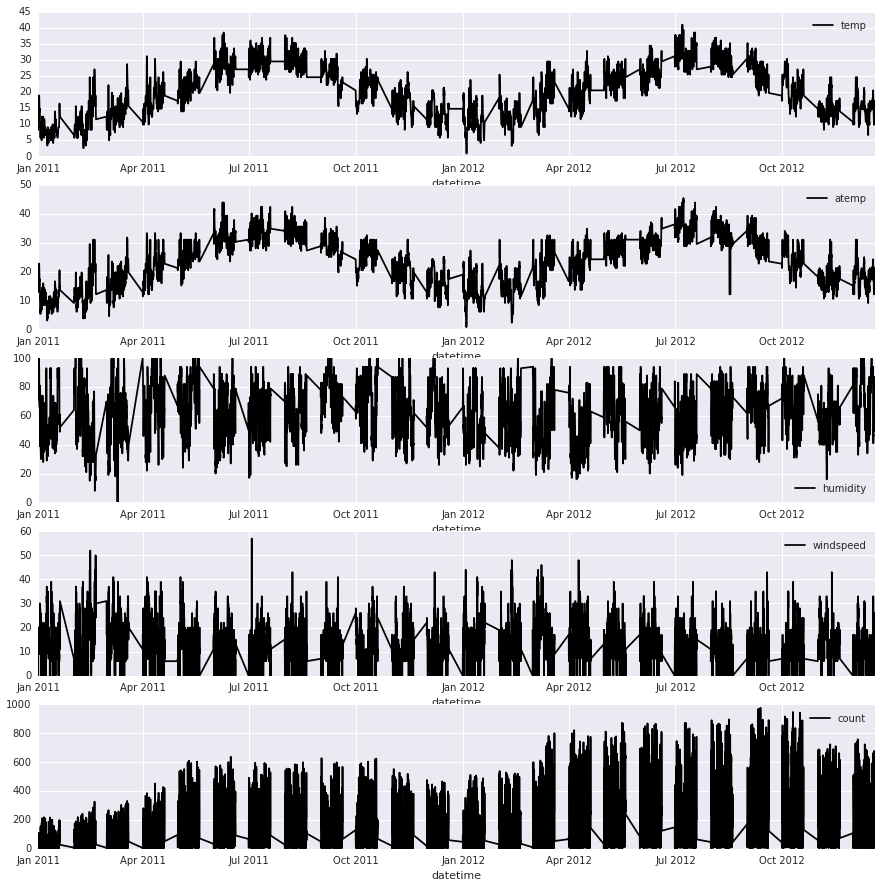

In [100]:
train_df[['temp','atemp','humidity','windspeed','count']]\
    .plot(subplots=True, sharex=False, sharey=False, figsize=(15,15))

'temp, 'atemp', and 'count' variables show clear seasonal patterns. On top of the seasonal pattern, 'count' also shows an upward trend from 2011 to 2012. We will try decomposite the seasonality in the time series analysis section.

#### Bivariate Analysis
Now let's look at relationships between variables. 

The pair-wise plots indicate:
1. 'temp' and 'atemp' are very strongly correlated and might cause multi-colinearity issues to our models.
2. There seems to be a positive relationship between 'temp'/'atemp' and 'count'.

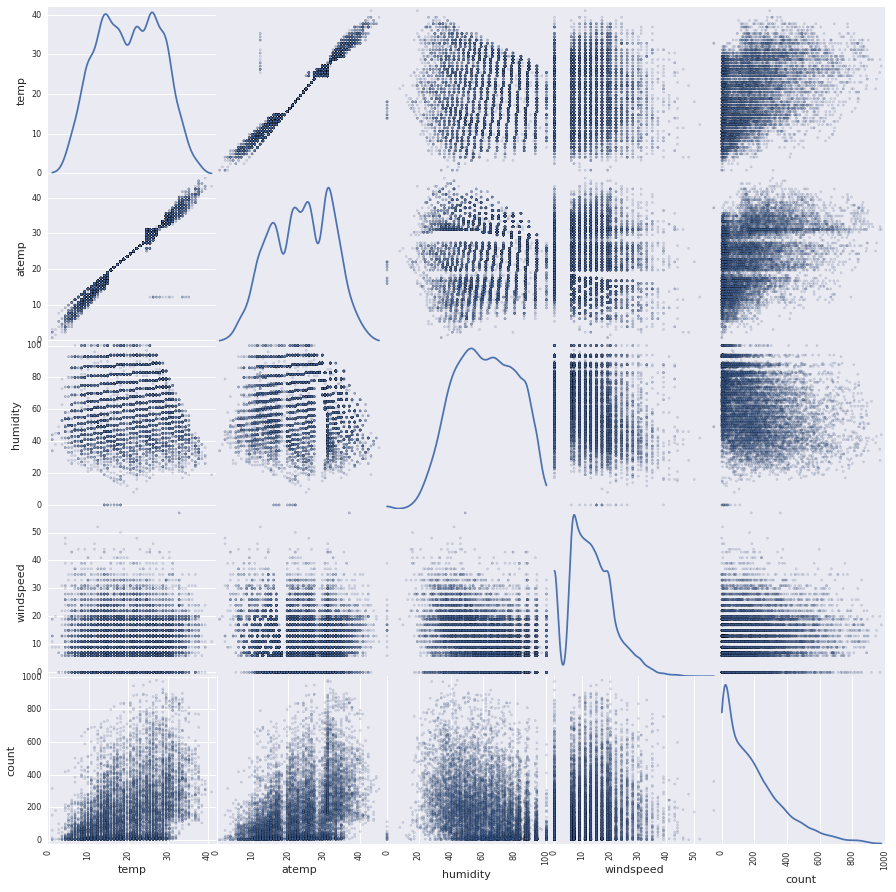

In [101]:
axes = pd.tools.plotting.scatter_matrix(train_df[['temp','atemp','humidity','windspeed','count']], \
                                        alpha=0.2, figsize=(15, 15), diagonal='kde')

Looking at statistics for weekends and weekdays as separate groups. The count variable seems to be similar across the two groups.

In [102]:
train_df.groupby('workingday').describe()

atemp       casual        count      holiday  \
workingday                                                             
0          count  3474.000000  3474.000000  3474.000000  3474.000000   
           mean     23.349837    59.308290   188.506621     0.089522   
           std       8.603684    72.669078   173.724015     0.285537   
           min       2.275000     0.000000     1.000000     0.000000   
           25%      16.665000     6.000000    44.000000     0.000000   
           50%      22.725000    25.000000   128.000000     0.000000   
           75%      31.060000    90.000000   304.000000     0.000000   
           max      45.455000   367.000000   783.000000     1.000000   
1          count  7412.000000  7412.000000  7412.000000  7412.000000   
           mean     23.798153    25.107663   193.011873     0.000000   
           std       8.410190    28.601591   184.513659     0.000000   
           min       0.760000     0.000000     1.000000     0.000000   
           25%      16.665000     3.000000    41.000000     0.000000   
           50%      24.240000    14.000000   151.000000     0.000000   
           75%      31.060000    39.000000   277.000000     0.000000   
           max      43.940000   240.000000   977.000000     0.000000   

                     humidity   registered       season         temp  \
workingday                                                             
0          count  3474.000000  3474.000000  3474.000000  3474.000000   
           mean     62.192286   129.198330     2.519862    19.889839   
           std      19.180711   108.657340     1.120334     7.859863   
           min      12.000000     0.000000     1.000000     3.280000   
           25%      47.000000    36.000000     2.000000    13.940000   
           50%      62.000000    99.000000     3.000000    18.860000   
           75%      78.000000   207.000000     4.000000    26.240000   
           max     100.000000   601.000000     4.000000    41.000000   
1          count  7412.000000  7412.000000  7412.000000  7412.000000   
           mean     61.743119   167.904209     2.500405    20.390696   
           std      19.274729   165.817966     1.114241     7.754755   
           min       0.000000     0.000000     1.000000     0.820000   
           25%      47.000000    36.000000     2.000000    13.940000   
           50%      61.000000   127.000000     2.000000    20.500000   
           75%      77.000000   233.000000     3.000000    26.240000   
           max     100.000000   886.000000     4.000000    38.540000   

                      weather    windspeed  
workingday                                  
0          count  3474.000000  3474.000000  
           mean      1.387162    12.639916  
           std       0.605253     8.147390  
           min       1.000000     0.000000  
           25%       1.000000     7.001500  
           50%       1.000000    11.001400  
           75%       2.000000    16.997900  
           max       3.000000    56.996900  
1          count  7412.000000  7412.000000  
           mean      1.433081    12.874143  
           std       0.646322     8.172040  
           min       1.000000     0.000000  
           25%       1.000000     7.001500  
           50%       1.000000    12.998000  
           75%       2.000000    16.997900  
           max       4.000000    51.998700

There appears to be a higher number of registered user rentals initiated during workdays compared to weekends. The trend is reversed for the number of non-registered user rentals initiated (the 'casual' variable). One hypothesis to explain this difference is that those who rent bikes during the weekday happen to be regulars and therefore more likely to be registered while those who rent bikes on the weekend are more likely to be unregistered tourists.

The net effect of these two reverse trends is that the difference in the total 'count' between working days and weekends is marginal. We can observe something similar for the holidays vs non-holidays sub samples (below).


Looking at statistics for holidays and non-holidays as separate groups.

In [103]:
train_df.groupby('holiday').describe()

atemp        casual         count      humidity  \
holiday                                                                 
0       count  10575.000000  10575.000000  10575.000000  10575.000000   
        mean      23.662662     35.646714    191.741655     61.880095   
        std        8.439687     49.535115    181.513131     19.292905   
        min        0.760000      0.000000      1.000000      0.000000   
        25%       16.665000      4.000000     43.000000     47.000000   
        50%       24.240000     16.000000    145.000000     62.000000   
        75%       31.060000     48.000000    283.000000     77.000000   
        max       45.455000    367.000000    977.000000    100.000000   
1       count    311.000000    311.000000    311.000000    311.000000   
        mean      23.397395     48.781350    185.877814     62.102894   
        std        9.598185     61.478009    168.300531     17.566712   
        min        6.060000      0.000000      1.000000     31.000000   
        25%       14.395000      5.000000     38.500000     46.000000   
        50%       24.240000     20.000000    133.000000     62.000000   
        75%       31.820000     70.500000    308.000000     76.000000   
        max       42.425000    242.000000    712.000000     94.000000   

                 registered        season          temp       weather  \
holiday                                                                 
0       count  10575.000000  10575.000000  10575.000000  10575.000000   
        mean     156.094941      2.500993     20.230466      1.419196   
        std      151.762822      1.115164      7.761737      0.635372   
        min        0.000000      1.000000      0.820000      1.000000   
        25%       36.000000      2.000000     13.940000      1.000000   
        50%      119.000000      2.000000     20.500000      1.000000   
        75%      223.000000      3.000000     26.240000      2.000000   
        max      886.000000      4.000000     41.000000      4.000000   
1       count    311.000000    311.000000    311.000000    311.000000   
        mean     137.096463      2.697749     20.244244      1.392283   
        std      122.715027      1.135339      8.760250      0.579604   
        min        1.000000      1.000000      4.100000      1.000000   
        25%       30.000000      2.000000     13.120000      1.000000   
        50%      104.000000      3.000000     20.500000      1.000000   
        75%      207.000000      4.000000     27.880000      2.000000   
        max      601.000000      4.000000     37.720000      3.000000   

                  windspeed    workingday  
holiday                                    
0       count  10575.000000  10575.000000  
        mean      12.787623      0.700898  
        std        8.155835      0.457886  
        min        0.000000      0.000000  
        25%        7.001500      0.000000  
        50%       12.998000      1.000000  
        75%       16.997900      1.000000  
        max       56.996900      1.000000  
1       count    311.000000    311.000000  
        mean      13.199711      0.000000  
        std        8.458933      0.000000  
        min        0.000000      0.000000  
        25%        7.001500      0.000000  
        50%       12.998000      0.000000  
        75%       19.001200      0.000000  
        max       39.000700      0.000000

There appears to be a higher number of registered user rentals initiated during non-holidays compared to non-holidays. The trend is reversed if we look at the number of non-registered user rentals initiated (the 'casual' variable). One hypothesis to explain this difference is that those who rent bikes during the non-holidays happen to be regulars and therefore more likely to be registered while those who rent bikes during holidays are more likely to be unregistered tourists.

The net effect of these two reverse trends is that the difference in the total 'count' between holdiays and non-holidays is marginal. We can observe something similar for the working days vs weekend sub samples (above).

### Baseline Modeling: OLS Linear Regression

#### Model Summary and Residual Plots
To construct a baseline model, we use every available variables in the dataset and run a simple linear regression over the whole training data set.

First, we will summarize the results of the linear model and plot the residuals to see if the linear model is a good fit. The residual plot shows an upward trend and an increase in variance of the residuals, which validate the assumption of zero mean and constant variance of linear regression model. A transformation on the target variable seems necessary.

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     480.0
Date:                Sun, 16 Aug 2015   Prob (F-statistic):               0.00
Time:                        22:06:11   Log-Likelihood:                -70400.
No. Observations:               10886   AIC:                         1.408e+05
Df Residuals:                   10877   BIC:                         1.409e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    135.7905      8.710     15.590      0.0

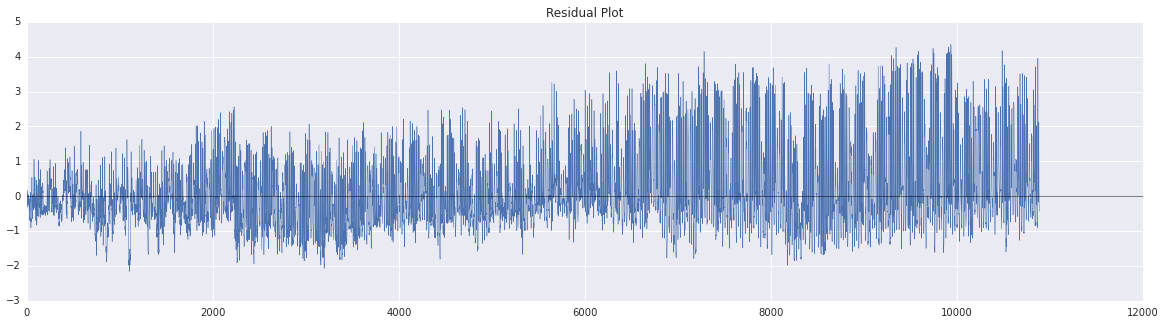

In [104]:
model = smf.ols(formula = \
        'count ~ season + holiday + workingday + weather + temp + atemp + humidity + windspeed', \
        data=train_df)

fitted = model.fit()
print fitted.summary()

infl = fitted.get_influence()
df_infl = infl.summary_frame()
#resid = fitted.resid

#RESIDUAL PLOT
plt.figure(figsize=(20,5))
plt.plot(df_infl.standard_resid,linewidth=.5)
plt.axhline(y=0,c='black',linewidth=.5)
plt.title('Residual Plot')
plt.show()

#### Model Diagnostics and Outlier Examination

Next, we want to examine the influence of each data point. We want to make sure that the model was not too heavily influenced by a few points. In addition, if this is the case, we want to make sure that this data is accurate and makes sense within the parameters of the model.

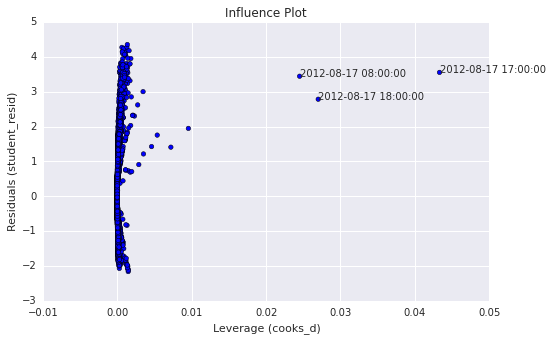

In [105]:
#INFLUENCE PLOT
plt.figure(figsize=(8,5))
plt.scatter(df_infl.cooks_d,df_infl.student_resid,linewidth=.5)
plt.xlabel('Leverage (cooks_d)')
plt.ylabel('Residuals (student_resid)')
plt.title('Influence Plot')
for i in range(0,len(df_infl)):
    if ((df_infl.cooks_d[i] > 0.015) & (df_infl.student_resid[i] > 2)):
        plt.annotate(df_infl.index[i],xy=(df_infl.cooks_d[i], df_infl.student_resid[i]))
plt.show()

It turns out that there are a handful of points (3 main points) that have high leverage and high residual value and thus have high influence on our model.


Next we took a look at those points to see what made them stand out:

In [106]:
outl1 = pd.DataFrame(train_df[(train_df.index == '2012-08-17 08:00:00')])
outl2 = pd.DataFrame(train_df[(train_df.index == '2012-08-17 18:00:00')])
outl3 = pd.DataFrame(train_df[(train_df.index == '2012-08-17 17:00:00')])
outl = [outl1,outl2,outl3]
outl = pd.concat(outl)
outl

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-08-17 08:00:00,3,0,1,1,27.88,12.12,65,8.9981,43,625,668
2012-08-17 18:00:00,3,0,1,2,33.62,12.12,38,16.9979,108,561,669
2012-08-17 17:00:00,3,0,1,1,33.62,12.12,36,22.0028,144,647,791


There seems to be a large discrepancy between 'temp' and 'atemp'. 

We were then interested in seeing if this discrepancy was a common occurrence or just an outlier:

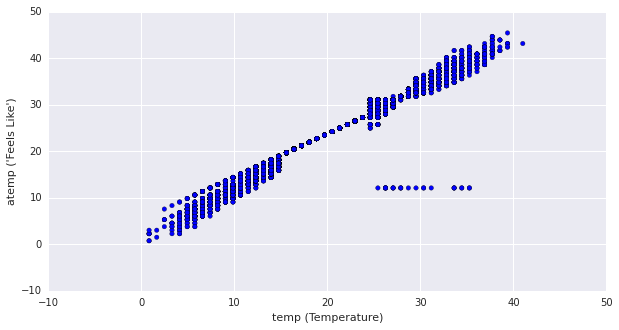

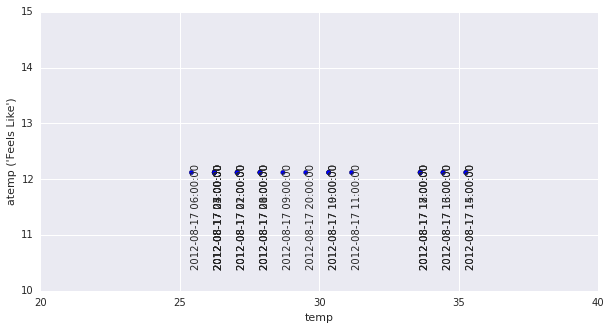

,temp,atemp
datetime,,
2012-08-17 00:00:00,27.88,12.12
2012-08-17 01:00:00,27.06,12.12
2012-08-17 02:00:00,27.06,12.12
2012-08-17 03:00:00,26.24,12.12
2012-08-17 04:00:00,26.24,12.12
2012-08-17 05:00:00,26.24,12.12
2012-08-17 06:00:00,25.42,12.12
2012-08-17 07:00:00,26.24,12.12
2012-08-17 08:00:00,27.88,12.12


In [107]:
plt.figure(figsize=(10,5))
plt.scatter(train_df.temp,train_df.atemp)
plt.xlabel("temp (Temperature)")
plt.ylabel("atemp ('Feels Like')")
plt.show()


plt.figure(figsize=(10,5))
plt.scatter(train_df.temp,train_df.atemp)
plt.xlabel("temp")
plt.ylabel("atemp ('Feels Like')")
plt.xlim(20,40)
plt.ylim(10,15)
for i in range(0,len(train_df)):
    if ((train_df.temp[i] > 20) & (train_df.atemp[i] < 15)):
        plt.annotate(train_df.index[i],xy=(train_df.temp[i], train_df.atemp[i]),rotation=90)
plt.show()


outlier_1 = train_df[train_df.temp - train_df.atemp >10]
outlier_1[['temp','atemp']]

It turns out that the entire day (August 17, 2012) was an outlier for 'atemp' vs. 'temp'

On that day, it was reported that the temperature (temp) ranged from 25.42 degress celsius to 35.26 degrees celsius. However, it was reported that the temperature felt like (atemp) it was 12.12 degrees celsius.

**Outlier** day where atemp and temp were drastically different

- 35.26 degrees celsius = 95.468 degrees Fahrenheit
- 12.12 degrees celsius = 53.816 degress Fahrenheit

**Component-Component plus Residual** (CCPR Plots)

In addition to residual and influence plots we also looked into partial regression. CCPR plots are a good way to examine the relationship between a given independent variable and a response variable (given that all the other indpendent variables are in the model as well)

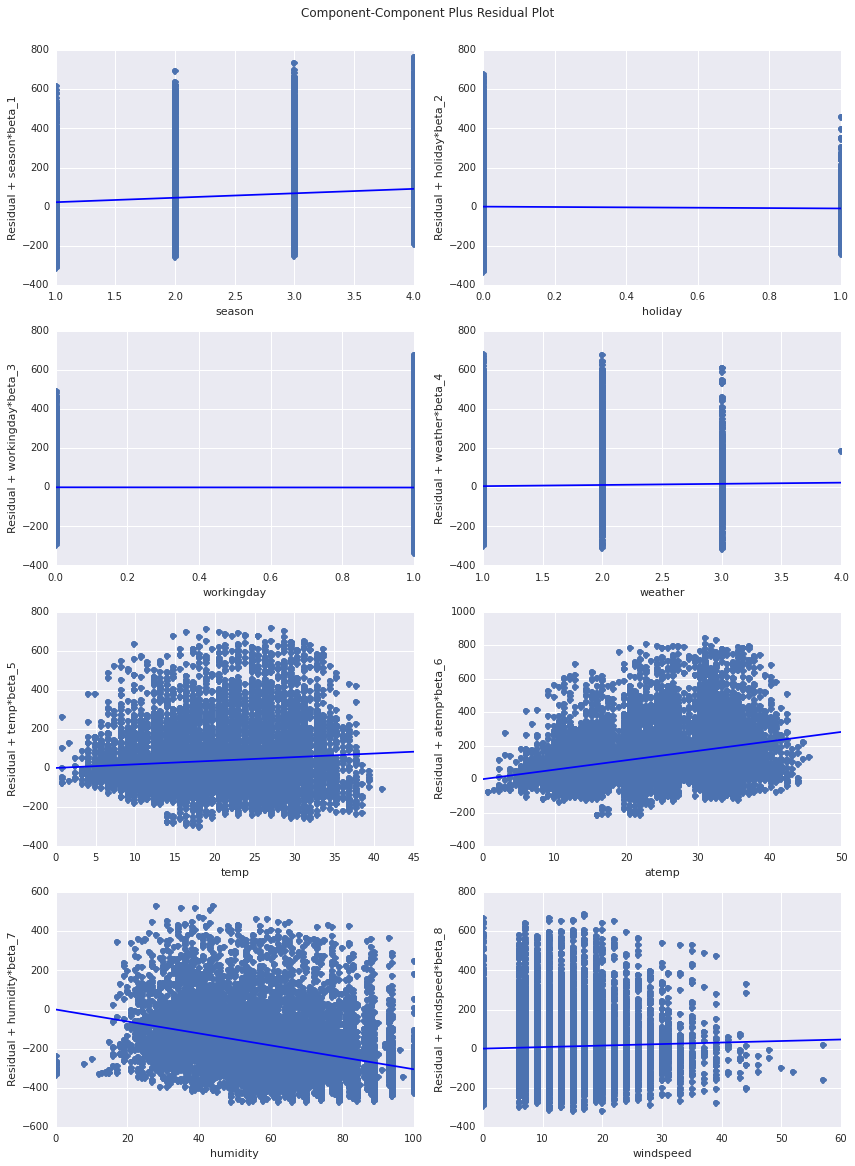

In [108]:
fig = plt.figure(figsize=(12, 20))
fig = sm.graphics.plot_ccpr_grid(fitted, fig=fig)

### Feature Engineering and Cross Validation

In this section, we try to improve our baseline model by removing outliers, transforming target variable, and constructing new features. We apply cross validation techniques to examine and compare different models.

#### Root Mean Squared Logarithmic Error (RMSLE)

Kaggle evaluates models using the Root Mean Squared Logarithmic Error (RMSLE) https://www.kaggle.com/c/bike-sharing-demand/details/evaluation. We also uses it as our main evaluation measure besides R-squared.

In [109]:
# Function to calculate Root Mean Squared Logarithmic Error
def get_RMSLE(p, a):
    s = 0.0
    n = len(p)
    for i in range(n):
        s += pow((np.log(p[i] + 1) - np.log(a[i] + 1)), 2)
    rmsle = pow((s/n), 0.5)
    return rmsle

#### K-fold Cross Validation

We perform K-fold cross validation on the training dataset and aggregate results across the folds to avoid overfitting.

In [110]:
# Function to iterate through the training and testing cross validation segments and
# run linear regression on each one, aggregating the results
def k_fold_cv(feat, targ, k, transform=True):
    cv = KFold(len(targ), n_folds=k)
    lr = LinearRegression(fit_intercept=True)

    rsqs = []
    rmsles = []
    precisions = []
    for traincv, testcv in cv:
        lr.fit(feat[traincv,], targ[traincv])
        preds = lr.predict(feat[testcv,])
        rsqs.append( lr.score(feat[traincv,], targ[traincv]) )
        
        # if target is log-transformed, transform back preds and reals
        if transform:
            preds = [np.exp(pred) - 1 for pred in preds]
            reals = [np.exp(t) - 1 for t in targ[testcv]]
        else:
            reals = targ[testcv]
            
        # eliminate negative predictions
        preds[preds < 0] = 0
        # counts can only be integer
        preds = np.round(preds)

        # the RMSLE calculation should always be performed on counts without transformation
        rmsles.append( get_RMSLE(preds, reals) )
    
    print 'Mean Rsq: %.4f' % np.array(rsqs).mean()
    print 'All Rsqs: ', rsqs
    print 'Mean RMSLE: %.4f' % np.array(rmsles).mean()
    print 'All RMSLEs: ', rmsles

#### Outlier Removal
As discussed in the previous section, we have identified a day of data as outliers based on the 'atemp'/'temp' discrepancy. We remove them from the train set and examine the effect on the baseline model.

Before removal, the baseline model has a mean Rsq of 0.2666 and a mean RMSLE of 1.4690 across 5-folds cross validation. After removal, we see an increase in mean Rsq (0.2682) and a drop in mean RMSLE (1.4651), suggesting the outlier removal helps the model.

In [111]:
train_feat = train_df[['season','holiday','workingday','weather','temp','atemp',\
                        'humidity','windspeed']].values
train_targ = np.transpose(train_df[['count']].values)[0]

print '\n----- 5-fold baseline model results -----'
k_fold_cv(train_feat, train_targ, 5, False)


----- 5-fold baseline model results -----
Mean Rsq: 0.2666
All Rsqs:  [0.23268595249559321, 0.29741365269741149, 0.26771366999607205, 0.25630955169014202, 0.27896366155899877]
Mean RMSLE: 1.4690
All RMSLEs:  [1.6619192406258045, 1.4834540369077238, 1.6503829129822385, 1.3029076729978499, 1.2463555519008582]


In [112]:
outliers = train_df[train_df.temp - train_df.atemp > 10]
train_df_no_outliers = train_df.loc[train_df.temp - train_df.atemp <= 10,:]
print train_df_no_outliers.shape

train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp',\
                                    'humidity','windspeed']].values
train_targ = np.transpose(train_df_no_outliers[['count']].values)[0]

print '\n----- 5-fold baseline model results: outliers removed -----'
k_fold_cv(train_feat, train_targ, 5, False)

(10862, 11)

----- 5-fold baseline model results: outliers removed -----
Mean Rsq: 0.2682
All Rsqs:  [0.23634246952042859, 0.29748579245736106, 0.26966004194626514, 0.26010195244682766, 0.2774286683956908]
Mean RMSLE: 1.4651
All RMSLEs:  [1.6652878118513466, 1.4746228202971849, 1.6498011914124031, 1.3064466513438924, 1.2295486138173202]


#### Target Variable Transformation
As mentioned in the EDA section, we want to transform the 'count' variable to be more normally distributed so that the assumptions of linear regression hold. Here we perform natural log transformation, with 1 added to each count to deal with zero counts.

After log transformation, the mean Rsq stays similar (0.2660) as expected and the mean RMSLE drops to 1.2655. Going forward, we always use the log-transformed counts as our target variable.


----- log-transformation results -----
Mean Rsq: 0.2660
All Rsqs:  [0.2419125994461272, 0.27705074870996926, 0.28772272114911923, 0.25833010747996077, 0.26495418043362529]
Mean RMSLE: 1.2655
All RMSLEs:  [1.3066111398490388, 1.2059543898214975, 1.2981591963120942, 1.2476010642549431, 1.2693575084563697]


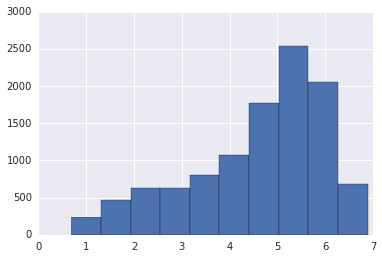

In [113]:
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp',\
                                    'humidity','windspeed']].values
# new target variable: log(count + 1)
train_targ = np.array([row['count'] + 1 for index, row in train_df_no_outliers[['count']].iterrows()])
train_targ = np.log(train_targ)
train_df_no_outliers.loc[:,'log_count'] = train_targ

plt.hist(train_targ)

print '\n----- log-transformation results -----'
k_fold_cv(train_feat, train_targ, 5)

#### Feature Engineering
###### Examine Multicolinearity
We saw a very high correlation between 'temp' and 'atemp' in our EDA section. Let's now examine the potential multicolinearity issue by removing 'temp' or 'atemp' from the model.

In both cases, the mean Rsq drops and the mean RMSLE increases. We decide the benefits of keep both variables in the model is high and conclude the multicolinearity is not a big issue here.

In [114]:
# remove atemp from the baseline model
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp',\
                                    'humidity','windspeed']].values
print '\n----- removing atemp -----'
k_fold_cv(train_feat, train_targ, 5)

# remove temp from the baseline model
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','atemp',\
                                    'humidity','windspeed']].values
print '\n----- removing temp -----'
k_fold_cv(train_feat, train_targ, 5)


----- removing atemp -----
Mean Rsq: 0.2617
All Rsqs:  [0.23574964841391532, 0.27480672741030931, 0.28218147088923506, 0.25435764757464474, 0.26127994239174046]
Mean RMSLE: 1.2709
All RMSLEs:  [1.3072756316925098, 1.2200036146390811, 1.2966077413822243, 1.2538150893261544, 1.2769158299685961]

----- removing temp -----
Mean Rsq: 0.2651
All Rsqs:  [0.23974103544813608, 0.27702024523602775, 0.28642713886906035, 0.25757902041538039, 0.26459504027533487]
Mean RMSLE: 1.2657
All RMSLEs:  [1.3024070663584324, 1.2077298983138516, 1.2969826922566319, 1.2487969421135083, 1.2724267827088038]


##### Add Hourly Trend
Next, we hypothesize that 'hour' is an important factor to predict counts, as the peak hours when people commute to and from work are expected to related to more bike usage. We extract 'hour' from the datetime varaible and add it to our OLS model.

As shown below, there is a significant increase in Rsq (from 0.2660 to 0.4663) and a decent drop in RMSLE (from 1.2655 to 1.0968). It confirms our hypothesis that hour is an important feature to add.

In [115]:
# extract hour as a single feature
train_df_no_outliers.loc[:,('hour')] = train_df_no_outliers.index.hour

# add hour to features
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp',\
                                    'humidity','windspeed','hour']].values
print '\n----- adding hour -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding hour -----
Mean Rsq: 0.4663
All Rsqs:  [0.45467505063203439, 0.46649096286922065, 0.484919780702739, 0.46212762942852603, 0.46343170465363681]
Mean RMSLE: 1.0968
All RMSLEs:  [1.1702780315767021, 1.0089721190794656, 1.1296636630154364, 1.085348722572, 1.0898198405078523]


##### Examine Daily and weekly Trend
In addition, there might be daily or weekly trend we could capture using day/week level features. We construct the following four features:
* day: the days of the datetime
* dayofweek: the day of the week with Monday=0, Sunday=6
* dayofyear: the ordinal day of year
* weekofyear: the ordinal week of the year

dayofweek and dayofyear both seem to help increase mean Rsq and decrease mean RMSLE. weekofyear increases the rsq and when combined with a yearly feature, decrease in the RMSLE. We decide to include these three new features into our model, which gives us a mean Rsq of 0.4697 and a mean RMSLE of 1.0961.

In [116]:
# extract day-related features
train_df_no_outliers.loc[:,('day')] = train_df_no_outliers.index.day
train_df_no_outliers.loc[:,('dayofweek')] = train_df_no_outliers.index.dayofweek
train_df_no_outliers.loc[:,('dayofyear')] = train_df_no_outliers.index.dayofyear
train_df_no_outliers.loc[:,('weekofyear')] = train_df_no_outliers.index.weekofyear

# add day to features
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                    'windspeed','hour','day']].values
print '\n----- adding day -----'
k_fold_cv(train_feat, train_targ, 5)

# add dayofweek to features
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                    'windspeed','hour','dayofweek']].values
print '\n----- adding day-of-week -----'
k_fold_cv(train_feat, train_targ, 5)

# add dayofyear to features
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                    'windspeed','hour','dayofyear']].values
print '\n----- adding day-of-year -----'
k_fold_cv(train_feat, train_targ, 5)

# add both dayofweek and dayofyear to features
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                    'windspeed','hour','dayofweek','dayofyear']].values
print '\n----- adding day-of-week and day-of-year -----'
k_fold_cv(train_feat, train_targ, 5)

#add dayofweek, dayofyear and weekofyear to features
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                    'windspeed','hour','dayofweek','dayofyear','weekofyear']].values
print '\n----- adding day-of-week, day-of-year and week-of-year -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding day -----
Mean Rsq: 0.4665
All Rsqs:  [0.4547792640879168, 0.46649148150867525, 0.48567964141744324, 0.462127815999686, 0.4634854080264641]
Mean RMSLE: 1.0977
All RMSLEs:  [1.1696620732686116, 1.0091040357736967, 1.1348449340282718, 1.0852185856028007, 1.089549362649253]

----- adding day-of-week -----
Mean Rsq: 0.4669
All Rsqs:  [0.45499177668090052, 0.46705289973634789, 0.48561822698384594, 0.46254162706913726, 0.46417015337675915]
Mean RMSLE: 1.0965
All RMSLEs:  [1.1686179096390894, 1.0091199362088989, 1.1299677267366823, 1.0843282933805625, 1.0905979578817215]

----- adding day-of-year -----
Mean Rsq: 0.4687
All Rsqs:  [0.45631823137722971, 0.46892407791274504, 0.49044528031524481, 0.46303215216588589, 0.46458196659611473]
Mean RMSLE: 1.0961
All RMSLEs:  [1.1614541449618827, 1.0091440206011011, 1.1490577771446318, 1.0794264051800928, 1.0814982021558681]

----- adding day-of-week and day-of-year -----
Mean Rsq: 0.4692
All Rsqs:  [0.45663706718737729, 0.4694973239214560

##### Add Yearly Trend
We discovered previously that there is a general upward trend in bike usage from 2011 to 2012. It might be helpful to extract 'year' as new feature and add to the model as well.

It turns out that 'year' does help to increase Rsqs to 0.4871, and also drives down RMSLE to 1.0268. We decide to include 'year' to our model.

In [117]:
# extract year as a single feature, 2011 as 0, 2012 as 1
train_df_no_outliers.loc[:,('year')] = train_df_no_outliers.index.year - 2011

# add year to features
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                    'windspeed','hour','dayofweek','dayofyear','weekofyear','year']].values

print '\n----- adding year -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding year -----
Mean Rsq: 0.4871
All Rsqs:  [0.47117069668419131, 0.48715864043371992, 0.50687017308949578, 0.486462547224499, 0.48394506627086653]
Mean RMSLE: 1.0268
All RMSLEs:  [1.0575411107140342, 0.9393018422303131, 1.0778955090236719, 1.0500219827516111, 1.0091645847549855]


### Time Series Analysis
In this section, we will use a few different time series analysis techniques to extract seasonality trends for the temperature variable. This can help explain a large degree of week-to-week and even month-to-month variability in the number of total rentals. 

####Seasonal decomposition
Visualizing the seasonal decomposition of the 'temp' variable.

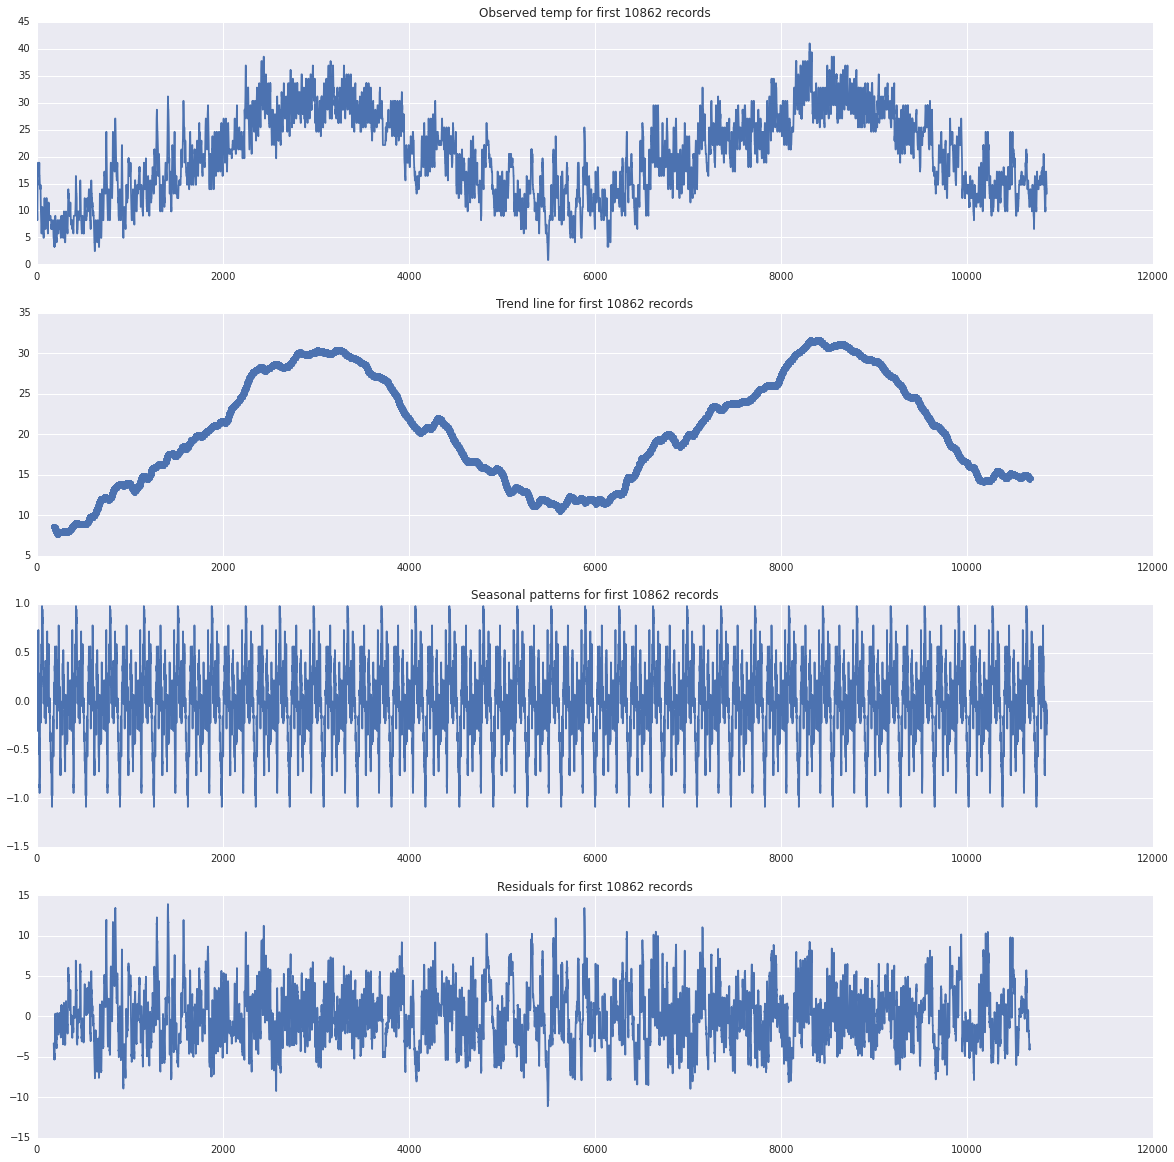

In [132]:
res = sm.tsa.seasonal_decompose(train_df_no_outliers.temp, model='additive', freq=365)
num_records = len(train_df_no_outliers)

fig, ax = plt.subplots(4,figsize=(20,20))

ax[0].plot(train_df_no_outliers.temp[:num_records])  
ax[0].set_title('Observed temp for first %s records' % num_records )

ax[1].plot(res.trend[:num_records], marker='o', linestyle='--')  
ax[1].set_title('Trend line for first %s records' % num_records)

ax[2].plot(res.seasonal[:num_records])
ax[2].set_title('Seasonal patterns for first %s records' % num_records )

ax[3].plot(res.resid[:num_records])  
ax[3].set_title('Residuals for first %s records' % num_records )


#### Auto-correlation and Partial auto-correlation
The auto-correlation function computes the correlation between a variable 
and itself for various values of lag (from 0 to 40 in this case). 

The partial auto-correlation function computes the correlation at each lag step that is
NOT already explained by any of the smaller lag steps. As we can see from the figure
below, there is a sharp jump around step=1 showing that the value at t-1 is the
strongest predictor

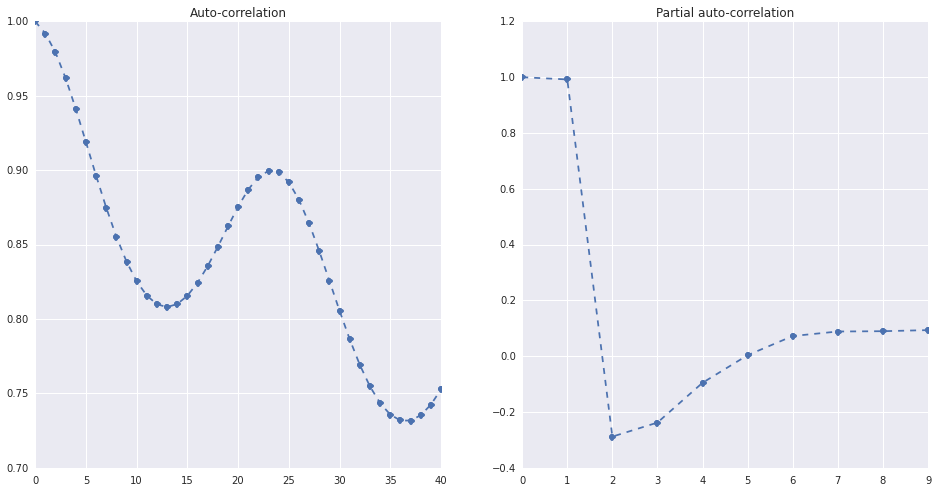

In [119]:
lag_correlations = acf(train_df_no_outliers.temp)
lag_partial_correlations = pacf(train_df_no_outliers.temp)

fig, ax = plt.subplots(1,2,figsize=(16,8))  

ax[0].plot(lag_correlations, marker='o', linestyle='--')
ax[0].set_title("Auto-correlation")

ax[1].plot(lag_partial_correlations[:10], marker='o', linestyle='--')  
ax[1].set_title('Partial auto-correlation')

####ARIMA model 1, 0, 0:
Exponential smoothing spreads out the impact of previous values using an
exponential weighting, so things that happened more recently are more impactful
than things that happened a long time ago.

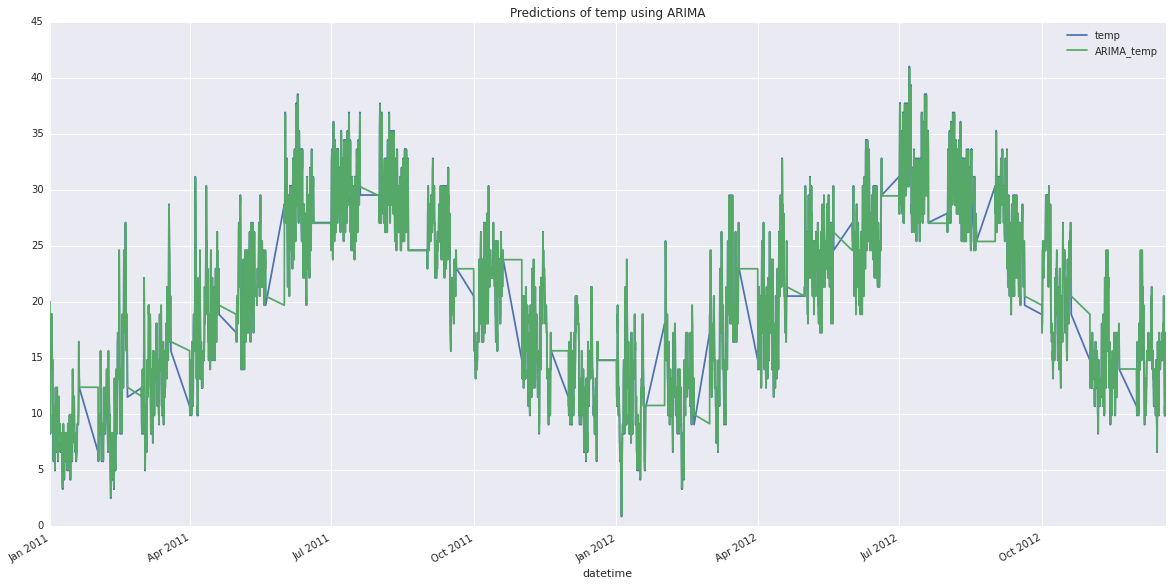

In [120]:
model = sm.tsa.ARIMA(train_df_no_outliers.temp, order=(1, 0, 0))  
results = model.fit(disp=-1)

train_df_no_outliers.loc[:,'ARIMA_temp'] = results.fittedvalues
train_df_no_outliers[['temp', 'ARIMA_temp']].plot(figsize=(20, 10), title='Predictions of temp using ARIMA')

#### Adding Historical Factors to Regression Model
We apply ARIMA(1,0,0) model on the four continuous variables and use the predicted values as new features to the linear regression model. It helps increase the mean Rsq to 0.5190 and decrease the mean RMSLE to 0.9955.

In [121]:
temp_model = sm.tsa.ARIMA(train_df_no_outliers.temp, order=(1, 0, 0))  
temp_pred = temp_model.fit(disp=-1)
train_df_no_outliers.loc[:,'temp_arima'] = temp_pred.fittedvalues

atemp_model = sm.tsa.ARIMA(train_df_no_outliers.atemp, order=(1, 0, 0))  
atemp_pred = atemp_model.fit(disp=-1)
train_df_no_outliers.loc[:,'atemp_arima'] = atemp_pred.fittedvalues

humidity_model = sm.tsa.ARIMA(train_df_no_outliers.humidity, order=(1, 0, 0))  
humidity_pred = humidity_model.fit(disp=-1)
train_df_no_outliers.loc[:,'humidity_arima'] = humidity_pred.fittedvalues

windspeed_model = sm.tsa.ARIMA(train_df_no_outliers.windspeed, order=(1, 0, 0))  
windspeed_pred = windspeed_model.fit(disp=-1)
train_df_no_outliers.loc[:,'windspeed_arima'] = windspeed_pred.fittedvalues

train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                   'windspeed','hour','dayofweek','dayofyear','weekofyear', 'year','temp_arima',\
                                   'atemp_arima','humidity_arima','windspeed_arima']].values

print '\n----- adding ARIMA factors -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding ARIMA factors -----
Mean Rsq: 0.5190
All Rsqs:  [0.50474693981714669, 0.51967739358766851, 0.54017789363827229, 0.51198826657485719, 0.51833734284491406]
Mean RMSLE: 0.9955
All RMSLEs:  [1.0264012589789266, 0.91458140236797825, 1.0539547689675703, 0.99432652472070882, 0.98824364860489444]


Extracting the average value across various time spans for the trend line generated from performing a seasonal decomposition. 

In [122]:
res = sm.tsa.seasonal_decompose(train_df_no_outliers.temp, model='additive', freq=365)

# Given an attribute of the datetime index such as 'dayofyear' or 'dayofweek', etc. this method
# returns the average value for the trend line extracted from the seasonal_decompose object

def add_trend_for(datetime):
    END_OF_NA = 182
    # Removing the na values at the beginning of the seasonal decomposition trend results
    trend = res.trend[END_OF_NA:]
    trend_dict = {}
    for time, trend_val in zip(datetime[END_OF_NA:], trend):
        if time in trend_dict:
            if not np.isnan(trend_val):
                trend_dict[time].append(trend_val)
        elif np.isnan(trend_val):
            trend_dict[time] = []
        else:
            trend_dict[time] = [trend_val]
    # Averaging across all the trend values within a given time period (eg: week or month)
    return [float(sum(trend_dict[i])/len(trend_dict[i])) for i in datetime]

train_df_no_outliers.loc[:,('trend_weekofyear')] = add_trend_for(train_df_no_outliers.index.weekofyear)
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                   'windspeed','hour','dayofweek','dayofyear','weekofyear', 'year',\
                                   'trend_weekofyear','temp_arima','atemp_arima','humidity_arima',\
                                   'windspeed_arima']].values
print '\n----- adding trend_weekofyear -----'
k_fold_cv(train_feat, train_targ, 10)

train_df_no_outliers.loc[:,('trend_month')] = add_trend_for(train_df_no_outliers.index.month)
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                   'windspeed','hour','dayofweek','dayofyear','weekofyear','year','trend_month',\
                                   'temp_arima','atemp_arima','humidity_arima','windspeed_arima']].values

print '\n----- adding trend_month -----'
k_fold_cv(train_feat, train_targ, 10)

train_df_no_outliers.loc[:,('trend_month')] = add_trend_for(train_df_no_outliers.index.month)
train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                   'windspeed','hour','dayofweek','dayofyear','weekofyear','year','trend_month',\
                                   'trend_weekofyear','temp_arima','atemp_arima','humidity_arima','windspeed_arima']].values

print '\n----- adding trend_month and trend_weekofyear -----'
k_fold_cv(train_feat, train_targ, 10)


----- adding trend_weekofyear -----
Mean Rsq: 0.5217
All Rsqs:  [0.50875042442953267, 0.52413244742148069, 0.51902547570455182, 0.52364222425636309, 0.52720264963217311, 0.53447071915869682, 0.52185753425734327, 0.51534297473834412, 0.51554107607530852, 0.52679145827313834]
Mean RMSLE: 0.9983
All RMSLEs:  [1.0524273441987761, 1.0043368166217195, 0.89024694927609571, 0.95000558722777984, 0.9875281886351801, 1.1214424895492459, 1.0432542933268087, 0.94475679573236948, 0.961839712468474, 1.0269354368813424]

----- adding trend_month -----
Mean Rsq: 0.5217
All Rsqs:  [0.5088952133789546, 0.52435263222293327, 0.51901095760672611, 0.52370321063425829, 0.52718028616729828, 0.53456460933430971, 0.52193464945922563, 0.51525841222708324, 0.51562118821536318, 0.52681914636850058]
Mean RMSLE: 0.9982
All RMSLEs:  [1.0532957589555991, 1.0059908638925956, 0.88974057130184958, 0.94980505176439578, 0.98644140481633835, 1.121645492232892, 1.042833272833622, 0.94349992062208321, 0.96183764036842512, 1.0

trend_weekofyear and trend_month both help increase mean Rsq (from 0.5190 to 0.5217) but they also increase the mean RMSLE (0.9955 to 0.9983 and 0.9982 resp). We decide to include trend_month into our model as it has a higher increase in mean rsq with a smaller increase to the mean RMSLE. Adding both trend_weekofyear and trend_month does not further add to this improvement by a significant amount so in the interest of parsimony, we leave our trend_weekofyear.

#### Adding Seasonal Components to Regression Model
Finally, we extract the seasonal components from the four continuous variables and add them to the linear regression model. We observe a slight increase in mean Rsq and the mean RMSLE stays almost the same. We decide to keep them in the model as well.

In [123]:
sd_temp = sm.tsa.seasonal_decompose(train_df_no_outliers.temp, model='additive', freq=365)
train_df_no_outliers.loc[:,('temp_season')] = sd_temp.seasonal

sd_atemp = sm.tsa.seasonal_decompose(train_df_no_outliers.atemp, model='additive', freq=365)
train_df_no_outliers.loc[:,('atemp_season')] = sd_atemp.seasonal

sd_humid = sm.tsa.seasonal_decompose(train_df_no_outliers.humidity, model='additive', freq=365)
train_df_no_outliers.loc[:,('humid_season')] = sd_humid.seasonal

sd_windspeed = sm.tsa.seasonal_decompose(train_df_no_outliers.windspeed, model='additive', freq=365)
train_df_no_outliers.loc[:,('windspeed_season')] = sd_windspeed.seasonal

train_feat = train_df_no_outliers[['season','holiday','workingday','weather','temp','atemp','humidity',\
                                   'windspeed','hour','dayofweek','dayofyear','weekofyear','year','trend_month',
                                   'temp_arima','atemp_arima','humidity_arima','windspeed_arima','temp_season',
                                   'atemp_season','humid_season','windspeed_season']].values

print '\n----- adding seasonal components -----'
k_fold_cv(train_feat, train_targ, 5)


----- adding seasonal components -----
Mean Rsq: 0.5210
All Rsqs:  [0.50764201047063517, 0.52120953991716978, 0.54216166603111937, 0.51374146564327539, 0.52006653975566874]
Mean RMSLE: 0.9945
All RMSLEs:  [1.0291944263600432, 0.91222581821913684, 1.0530832026180765, 0.991526931527558, 0.98629592242577635]


## Final Model and Conclusions

### Final Model
Our final regression model looks like:

    log(count) ~ season + holiday + workingday + weather + temp + atemp + humidity + windspeed + hour + dayofweek + dayofyear + weekofyear + year + trend_month + temp_arima + atemp_arima + humidity_arima + windspeed_arima + temp_season + atemp_season + humid_season + windspeed_season

From the model summary and residual plots, you can see there are great improvements compared with the baseline model. 

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     588.5
Date:                Sun, 16 Aug 2015   Prob (F-statistic):               0.00
Time:                        22:33:11   Log-Likelihood:                -15224.
No. Observations:               10862   AIC:                         3.049e+04
Df Residuals:                   10841   BIC:                         3.064e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            2.5041      0.086  

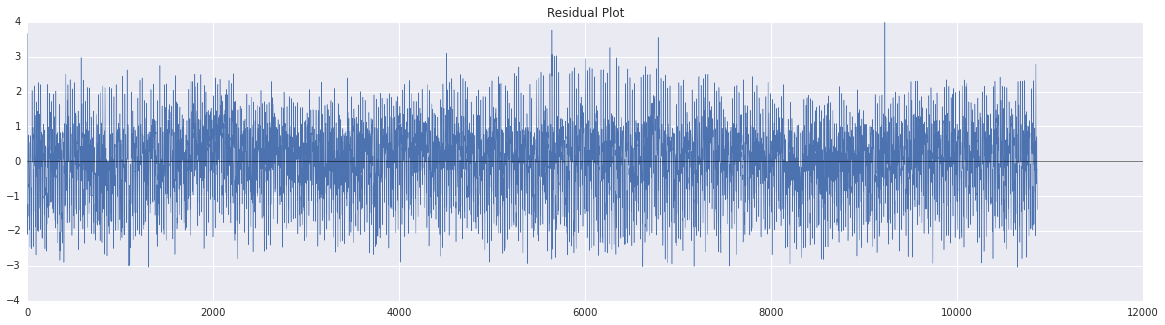

In [135]:
final_model = smf.ols(formula = 'log_count ~ season + holiday + workingday + weather + temp + atemp + humidity + \
                                windspeed + hour + dayofweek + dayofyear + year + temp_arima + atemp_arima + \
                                humidity_arima + windspeed_arima + temp_season + atemp_season + humid_season + \
                                windspeed_season', data=train_df_no_outliers)
fitted = final_model.fit()
print fitted.summary()

infl = fitted.get_influence()
df_infl = infl.summary_frame()

# residual plots
plt.figure(figsize=(20,5))
plt.plot(df_infl.standard_resid,linewidth=.5)
plt.axhline(y=0,c='black',linewidth=.5)
plt.title('Residual Plot')
plt.show()

### Predictions on Test Set
We construct the new features on the test set and make predictions for submission.

In [ ]:
# Repeat the feature engneering on the test set
test_df.loc[:,'hour'] = test_df.index.hour
test_df.loc[:,'dayofweek'] = test_df.index.dayofweek
test_df.loc[:,'dayofyear'] = test_df.index.dayofyear
test_df.loc[:,'year'] = test_df.index.year - 2011
test_df.loc[:,'weekofyear'] = test_df.index.weekofyear
test_df.loc[:,('trend_weekofyear')] = add_trend_for(test_df.index.weekofyear)

temp_model = sm.tsa.ARIMA(test_df.temp, order=(1, 0, 0)).fit(disp=-1)  
test_df.loc[:,'temp_arima'] = temp_model.fittedvalues
atemp_model = sm.tsa.ARIMA(test_df.atemp, order=(1, 0, 0)).fit(disp=-1)  
test_df.loc[:,'atemp_arima'] = atemp_model.fittedvalues
humidity_model = sm.tsa.ARIMA(test_df.humidity, order=(1, 0, 0)).fit(disp=-1)  
test_df.loc[:,'humidity_arima'] = humidity_model.fittedvalues
windspeed_model = sm.tsa.ARIMA(test_df.windspeed, order=(1, 0, 0)).fit(disp=-1)  
test_df.loc[:,'windspeed_arima'] = windspeed_model.fittedvalues

test_df.loc[:,'temp_season'] = sm.tsa.seasonal_decompose(test_df.temp, model='additive', freq=365).seasonal
test_df.loc[:,'atemp_season'] = sm.tsa.seasonal_decompose(test_df.atemp, model='additive', freq=365).seasonal
test_df.loc[:,'humid_season'] = sm.tsa.seasonal_decompose(test_df.humidity, model='additive', freq=365).seasonal
test_df.loc[:,'windspeed_season'] = sm.tsa.seasonal_decompose(test_df.windspeed, model='additive', freq=365).seasonal

After visualizing our predictions, we found that there are some really big predictions we made. Given that the maximum count we see in the training set is 977, we believe that predictions over 1000 are too extreme. Thus, we apply a trancation at value 1000: predictions that over 1000 are assigned to 1000.

In [ ]:
# generate predictions
preds = fitted.predict(test_df)

# revert log-transformation
preds = [np.exp(pred) - 1 for pred in preds]      
# eliminate negative predictions
preds[preds < 0] = 0
# counts can only be integer
preds = np.round(preds)

# visualize our predictions
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(preds)
ax[1].hist(preds)

# apply truncation on the predictions
preds[preds > 1000] = 1000

In [ ]:
test_df['count'] = preds
test_df.reset_index()[['datetime', 'count']].to_csv('../submission/submission_20150816.csv', index=False)

### Conclusions

According to Kaggle, the mean value benchmark of the RMSLE is 1.5846 and the top winner is 0.2155. Our model is definitely above average, but still has room to improve. Currently, our model focuses on linear regression and time series analysis. There are other models and techniques that worth exploring, such as generalized linear model and boosted regression trees. 